#### **Imports**

In [80]:
import pandas as pd
import numpy as np
import requests
import time
import nltk
import regex as re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
import warnings 
warnings.filterwarnings("ignore")

#### **Read in .csv file and remove first column**

In [81]:
# read in dataframe saved as .csv file
df = pd.read_csv('comments.csv')
# drop first column
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,author,body,score,created_utc,subreddit,body_word_count
0,RobusEtCeleritas,None of that means anything You clearly have ...,3,1627142891,1,11
1,hydroxypcp,The legal limit varies among countries It s c...,0,1627140964,1,130
2,AnthillOmbudsman,But magma chambers aren t hollow caverns I m...,1,1627140360,1,14
3,AWormDude,According to this study https www research...,5,1627139388,1,487
4,Trypanosoma_,Look up TH cellular response vs TH humora...,-4,1627136260,1,57


In [82]:
all_stop_words = stopwords.words('english')
new_words=('https', 'com', 'www', 'really', 'would', 'gt', 'like', 'also', 'get', 'even', 'much', 'could', 'see', 'really', 'know')
for i in new_words:
    all_stop_words.append(i)

#### **X, y, train_test_split**

In [83]:
X = df[['body']]
y = df['subreddit']

X = [word.lower().split() for word in df['body']]
posts_list = []
for post in X:
    meaningful_words = [word for word in post if word not in all_stop_words]
    meaningful_post = " ".join(meaningful_words)
    posts_list.append(meaningful_post)
    
modeltext = pd.Series(posts_list)
df['body'] = modeltext
X = df['body']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                   y,
                                   train_size=0.75,
                                   stratify=y,
                                   random_state=42)

#### **Baseline Accuracy**

In [84]:
y.value_counts(normalize=True)

0    0.699791
1    0.300209
Name: subreddit, dtype: float64

#### **Instantiate CountVectorizer**

In [85]:
cv = CountVectorizer(ngram_range=(1,1), min_df=3, max_df=.85)

cv.fit(X_train)

X_train_cv=cv.transform(X_train)
X_test_cv=cv.transform(X_test)

##### **DecisionTreeClassifier**

In [89]:
%time
dtc = DecisionTreeClassifier(max_depth=15)
dtc.fit(X_train_cv, y_train)
print(dtc.score(X_train_cv, y_train))
print(dtc.score(X_test_cv,y_test))

Wall time: 0 ns
0.786252999657182
0.7716930196683378


In [91]:
predictions_dtc = dtc.predict(X_test_cv)
print(f'Accuracy Score: {accuracy_score(y_test, predictions_dtc)}')

Accuracy Score: 0.7716930196683378


##### **AdaBoostClassifier**

In [87]:
%%time
abc = AdaBoostClassifier(random_state=22, n_estimators=400)
abc.fit(X_train_cv,y_train)
print(abc.score(X_train_cv, y_train))
print(abc.score(X_test_cv, y_test))

0.8803136784367501
0.852037536958478
Wall time: 16.9 s


In [93]:
predictions_abc = abc.predict(X_test_cv)
print(f'Accuracy Score: {accuracy_score(y_test, predictions_abc)}')

Accuracy Score: 0.852037536958478


##### **GradientBoostingClassifier**

In [94]:
%%time
gbc = GradientBoostingClassifier(verbose=1, n_estimators = 400, max_depth=4, random_state=42)
gbc.fit(X_train_cv, y_train)
print(gbc.score(X_train_cv, y_train))
print(gbc.score(X_test_cv, y_test))

      Iter       Train Loss   Remaining Time 
         1           1.2018           58.47s
         2           1.1850           46.65s
         3           1.1702           43.64s
         4           1.1579           41.12s
         5           1.1462           40.30s
         6           1.1362           38.61s
         7           1.1269           37.64s
         8           1.1186           36.92s
         9           1.1105           36.33s
        10           1.1036           35.85s
        20           1.0482           35.56s
        30           1.0086           34.46s
        40           0.9788           33.30s
        50           0.9534           31.53s
        60           0.9317           29.94s
        70           0.9130           28.26s
        80           0.8958           27.07s
        90           0.8809           25.80s
       100           0.8665           24.83s
       200           0.7704           15.33s
       300           0.7108            7.40s
       40

In [98]:
predictions_gbc = gbc.predict(X_test_cv)
print(f'Accuracy Score: {accuracy_score(y_test, predictions_gbc)}')

Accuracy Score: 0.8400822727857051


##### **XGBClassifier**

In [96]:
%%time
xg = XGBClassifier(subsample = 0.5, eval_metric='mlogloss')
xg.fit(X_train_cv, y_train)
print(xg.score(X_train_cv, y_train))
print(xg.score(X_test_cv, y_test))

0.8681007884813164
0.8421390924283327
Wall time: 3.28 s


In [97]:
predictions_xg = xg.predict(X_test_cv)
print(f'Accuracy Score: {accuracy_score(y_test, predictions_xg)}')

Accuracy Score: 0.8421390924283327


#### **Best Score: ADABoostClassifier Confusion Matrix**

Specificity: 0.9410360029390155


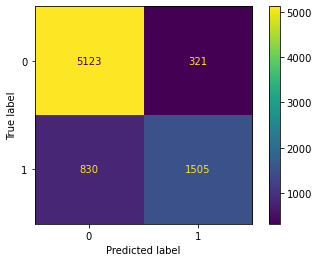

In [99]:
cm = confusion_matrix(y_test, predictions_abc)
tn, fp, fn, tp = cm.ravel()

# Calculate specificity
spec = tn / (tn + fp)

print('Specificity:', spec)
ConfusionMatrixDisplay(cm).plot();